In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
from datetime import datetime, date
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager

import geopandas
import branca.colormap as cm
from branca.element import Template, MacroElement
import folium
from folium import plugins

In [2]:
# mac os
font_path = '/Library/Fonts/simhei.ttf'
fontP = font_manager.FontProperties(fname=font_path)
fontP.set_size(14)


In [3]:
tot_pop_df = pd.read_excel('census_2020.xlsx', engine='openpyxl', sheet_name='total_pop')
pop_province_df = pd.read_excel('census_2020.xlsx', engine='openpyxl', sheet_name='pop_province')
gender_df = pd.read_excel('census_2020.xlsx', engine='openpyxl', sheet_name='gender')
age_df = pd.read_excel('census_2020.xlsx', engine='openpyxl', sheet_name='age')
educ_df = pd.read_excel('census_2020.xlsx', engine='openpyxl', sheet_name='educ')
educ_province_df = pd.read_excel('census_2020.xlsx', engine='openpyxl', sheet_name='educ_province')

province_gdf = geopandas.read_file('../geo_datasets/china_province_geo.json', driver='JSON')
china_gdf = geopandas.read_file('../geo_datasets/china_geo.json', driver='JSON')

In [4]:
def autolabel_lineplot(ax, df, col_name, color):
    """
    Attach a text label above each line displaying its height
    """
    for i, val in enumerate(df[col_name]):
        ax.text(df.index[i],
                1.05 * val,
                val,
                color=color,
                rotation=0,
                fontsize=12)



def autolabel_simple_barplot(ax, rects, color, offset = 0.5):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height().round(2).astype(float)
        ax.text(rect.get_x() + rect.get_width() / 2.,
                offset + height,
                '%1.1f' % height,
                fontsize=13,
                ha='center', va='center', color=color)

## 全国人口情况

全国总人口为1443497378人，其中：
- 普查登记的大陆31个省、自治区、直辖市和现役军人的人口共1411778724人；
- 香港特别行政区人口为7474200人；
- 澳门特别行政区人口为683218人；
- 台湾地区人口为23561236人。

/Users/jingwen/github/python-playground/_venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:2020: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/jingwen/github/python-playground/_venv/lib/python3.9/site-packages/matplotlib/axes/_base.py:249: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/jingwen/github/python-playground/_venv/lib/python3.9/site-packages/matplotlib/axes/_base.py:251: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


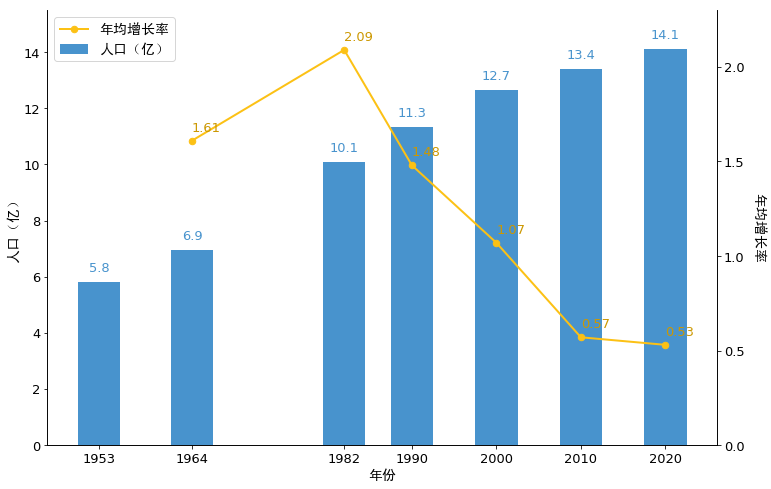

In [5]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
width = 5
rects1 = axarr.bar(tot_pop_df['年份'],
                   tot_pop_df['人口（亿）'],
                   width=width,
                   color='#4893cd')

axarr.tick_params(labelsize=13)
axarr.set_xlabel('年份', size=13, fontproperties=fontP)
axarr.set_ylabel('人口（亿）', size=13, fontproperties=fontP)
axarr.set_xticks(tot_pop_df['年份'])
axarr.set_xticklabels(tot_pop_df['年份'])
axarr.set_ylim(0, 15.5)
axarr.spines['top'].set_visible(False)
autolabel_simple_barplot(axarr, rects=rects1, color='#4893cd')

ax_02 = axarr.twinx()
line_rate, = ax_02.plot(tot_pop_df['年份'],
                   tot_pop_df['年均增长率'],
                           color='#fcc115',
                           linewidth=2,
                           marker='.',
                           markersize=13)
ax_02.tick_params(labelsize=13)
ax_02.set_ylim(0, 2.3)
ax_02.spines['top'].set_visible(False)
ax_02.set_ylabel('年均增长率', size=13, rotation=270, labelpad=20, fontproperties=fontP)

for i, val in enumerate(tot_pop_df['年均增长率'][1:]):
    ax_02.text(tot_pop_df['年份'][i+1],
               0.05 + val,
               val,
               color='#CC9801',
               rotation=0,
               fontsize=13)

ax_02.legend(handles=(line_rate, rects1),
             fontsize=13,
             labels=('年均增长率', '人口（亿）'), loc=2, prop=fontP)


全国人口与2010年第六次全国人口普查的1339724852人相比，增加72053872人，增长5.38%，年平均增长率为0.53%。

## 地区人口情况

In [6]:
province_pop_geo = pd.merge(pop_province_df,
                            province_gdf[['name', 'geometry']],
                            left_on='地区',
                            right_on='name')

province_pop_geo = province_pop_geo.drop(columns='name')
province_pop_geo = province_pop_geo.dropna()

In [7]:
crs = {'init': 'epsg:4326'}
province_pop_gdf = geopandas.GeoDataFrame(province_pop_geo, crs=crs)

/Users/jingwen/github/python-playground/_venv/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-7-4fb6cacdbce6>:2: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  province_pop_gdf = geopandas.GeoDataFrame(province_pop_geo, crs=crs)


In [8]:
template_province = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">

<body> 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:16px; right: 20px; top: 20px;'>
<meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
<div class='legend-title'>Population proportion</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#fdeed5;opacity:1;'></span>0.0% - 1.4%</li>
    <li><span style='background:#f6a88e;opacity:1;'></span>1.4% - 1.8%</li>
    <li><span style='background:#e86558;opacity:1;'></span>1.8% - 2.8%</li>
    <li><span style='background:#d13035;opacity:1;'></span>2.8% - 3.6%</li>
    <li><span style='background:#8c1f28;opacity:1;'></span>3.6% - 5.2%</li>
    <li><span style='background:#59060a;opacity:1;'></span>> 5.2%</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [9]:
template_province_title = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<body>

<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:0px; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:25px; left: 60px; top: 0px;'>
<div class='legend-title'>Population distribution</div>
<div class='legend-scale'><font size="3">Mainland China / 31 provinces, autonomous regions & municipalities / November 1, 2020 </font></div>
</div>

</body>
</html>

{% endmacro %}"""


In [10]:
province_pop_gdf.describe(percentiles=(0.16, 0.32, 0.67, 0.83))

,人口,比重（2020）
count,31.0,31.0
mean,45476733.0,3.2
std,30506939.6,2.2
min,3648100.0,0.3
16%,20287677.8,1.4
32%,25519339.4,1.8
50%,39528999.0,2.8
67%,50889379.3,3.6
83%,73793697.9,5.2
max,126012510.0,8.9


In [11]:
province_map = folium.Map(location=[36.130926, 106.925774],
                          zoom_start=4, tiles='cartodbpositron')

colormap_province = cm.StepColormap(
    colors=['#fdeed5', '#f6a88e', '#e86558',
            '#d13035', '#8c1f28', '#59060a'],
    vmin=min(province_pop_gdf['比重（2020）']),
    vmax=max(province_pop_gdf['比重（2020）']),
    index=[1.4, 1.8, 2.8, 3.6, 5.2, 10])

style_function = lambda x: {
    'fillColor': colormap_province(x['properties']['比重（2020）']),
    'color': '',
    'weight': 0.0001,
    'fillOpacity': 1
}

folium.GeoJson(
    province_pop_gdf[province_pop_gdf['比重（2020）']>0][['地区', '比重（2020）', 'geometry']],
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
            fields=['地区', '比重（2020）'],
            aliases=['地区', '比重（2020）'],
            localize=False
        ),
    name='confirmed').add_to(province_map)

folium.GeoJson(
    province_gdf,
    style_function = lambda x: {
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0
    },
    name='Province').add_to(province_map)

folium.GeoJson(
    china_gdf,
    style_function = lambda x: {
        'color': 'black',
        'weight': 2.5,
        'fillOpacity': 0
    },
    name='China').add_to(province_map)

macro = MacroElement()
macro._template = Template(template_province)
macro2 = MacroElement()
macro2._template = Template(template_province_title)
province_map.get_root().add_child(macro)
province_map.get_root().add_child(macro2)

In [12]:
province_map.save('province_population_map.html')

31个省份中，人口超过1亿人的省份有2个，在5000万人至1亿人之间的省份有9个，在1000万人至5000万人之间的省份有17个，少于1000万人的省份有3个。其中，人口居前五位的省份合计人口占全国人口比重为35.09%。

分区域看，东部地区人口为563717119人，占39.93%；中部地区人口为364694362人，占25.83%；西部地区人口为382852295人，占27.12%；东北地区人口为98514948人，占6.98%。

与2010年第六次全国人口普查相比，31个省份中，有25个省份人口增加。人口增长较多的5个省份依次为：广东、浙江、江苏、山东、河南，分别增加21709378人、10140697人、6088113人、5734388人、5341952人。

分区域看，与2010年第六次全国人口普查相比，东部地区人口所占比重上升2.15个百分点，中部地区人口所占比重下降0.79个百分点，西部地区人口所占比重上升0.22个百分点，东北地区人口所占比重下降1.20个百分点。

东部地区是指北京、天津、河北、上海、江苏、浙江、福建、山东、广东和海南10省（市）；中部地区是指山西、安徽、江西、河南、湖北和湖南6省；西部地区是指内蒙古、广西、重庆、四川、贵州、云南、西藏、陕西、甘肃、青海、宁夏和新疆12省（区、市）；东北地区是指辽宁、吉林和黑龙江3省。

## 人口性别构成情况

全国人口中，男性人口为723339956人，占51.24%；女性人口为688438768人，占48.76%。总人口性别比（以女性为100，男性对女性的比例）为105.07，与2010年第六次全国人口普查基本持平。

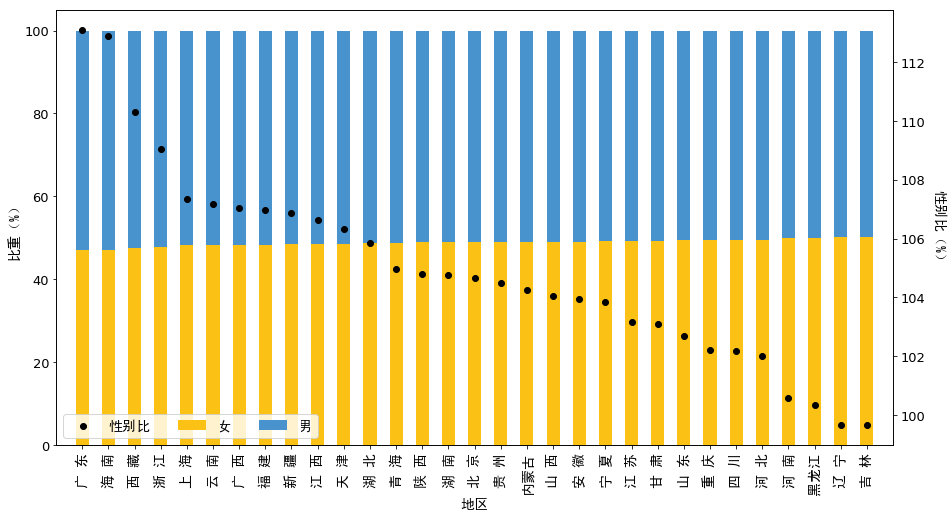

In [13]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
width = 0.5
rect1 = axarr.bar(gender_df.index,
                  gender_df['比重-女'],
                  width=width,
                  color='#fcc115')
rect2 = axarr.bar(gender_df.index,
                  gender_df['比重-男'],
                  bottom=gender_df['比重-女'],
                  width=width,
                  color='#4893cd')

axarr.tick_params(labelsize=13)
axarr.set_xlabel('地区', size=13, fontproperties=fontP)
axarr.set_ylabel('比重（%）', size=13, fontproperties=fontP)
axarr.set_xticks(gender_df.index)
axarr.set_xticklabels(gender_df['地区'], rotation=90, fontproperties=fontP)
axarr.set_xlim(-1, 31)

ax_02 = axarr.twinx()
scatter = ax_02.scatter(gender_df.index, gender_df['性别比'],
                        color='black')

ax_02.tick_params(labelsize=13)
ax_02.set_ylabel('性别比（%）', size=13, rotation=270, labelpad=20, fontproperties=fontP)
ax_02.legend(handles=(scatter, rect1, rect2),
             fontsize=13,
             labels=('性别比', '女', '男'),
             ncol=3, loc=3, prop=fontP)


全国人口中，男性人口为723339956人，占51.24%；女性人口为688438768人，占48.76%。总人口性别比（以女性为100，男性对女性的比例）为105.07，与2010年第六次全国人口普查基本持平。

31个省份中，总人口性别比在100以下的省份有2个，在100至105之间的省份有17个，在105至110之间的省份有9个，在110以上的省份有3个。


## 人口年龄构成情况

全国人口中，0—14岁人口为253383938人，占17.95%；15—59岁人口为894376020人，占63.35%；60岁及以上人口为264018766人，占18.70%，其中65岁及以上人口为190635280人，占13.50%。与2010年第六次全国人口普查相比，0—14岁人口的比重上升1.35个百分点，15—59岁人口的比重下降6.79个百分点，60岁及以上人口的比重上升5.44个百分点，65岁及以上人口的比重上升4.63个百分点。

In [14]:
age_pct_20vs10 = pd.DataFrame({
    'age_class':['0-14岁', '15-59岁', '60岁及以上'],
    '2010':[17.95-1.35, 63.35+6.79, 18.7-5.44],
    '2020':[17.95, 63.35, 18.7]
})

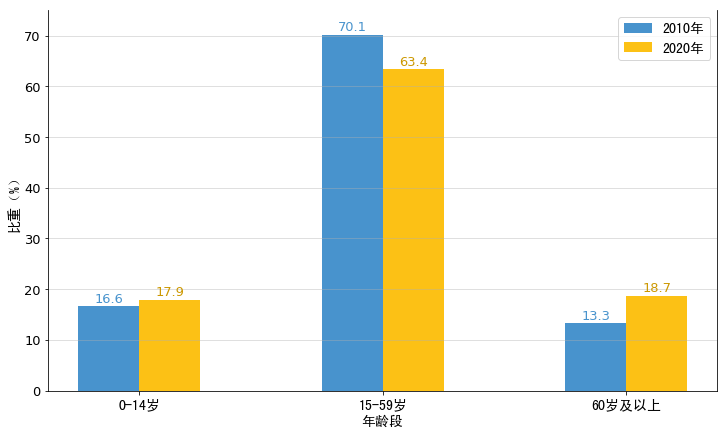

In [15]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
width = 0.25
rect1 = axarr.bar(age_pct_20vs10.index-width/2,
                  age_pct_20vs10['2010'],
                  width=width,
                  color='#4893cd')
rect2 = axarr.bar(age_pct_20vs10.index+width/2,
                  age_pct_20vs10['2020'],
                  width=width,
                  color='#fcc115')

axarr.tick_params(labelsize=13)
axarr.set_xticks(age_pct_20vs10.index)
axarr.set_xticklabels(age_pct_20vs10['age_class'], fontproperties=fontP)
axarr.set_xlabel('年龄段', size=13, fontproperties=fontP)
axarr.set_ylabel('比重（%）', size=13, fontproperties=fontP)
axarr.set_ylim(0, 75)
axarr.grid(which='major', axis='y', alpha=0.5)
axarr.spines['top'].set_visible(False)

axarr.legend(handles=(rect1, rect2),
             fontsize=13,
             labels=('2010年', '2020年'),
             prop=fontP)

autolabel_simple_barplot(axarr, rects=rect1, color='#4893cd', offset=1.5)
autolabel_simple_barplot(axarr, rects=rect2, color='#CC9801', offset=1.5)



In [16]:
age_df = age_df[1:].sort_values('比重60岁及以上', ascending=False).reset_index(drop=True)

Text(-0.21,87,'25.72')

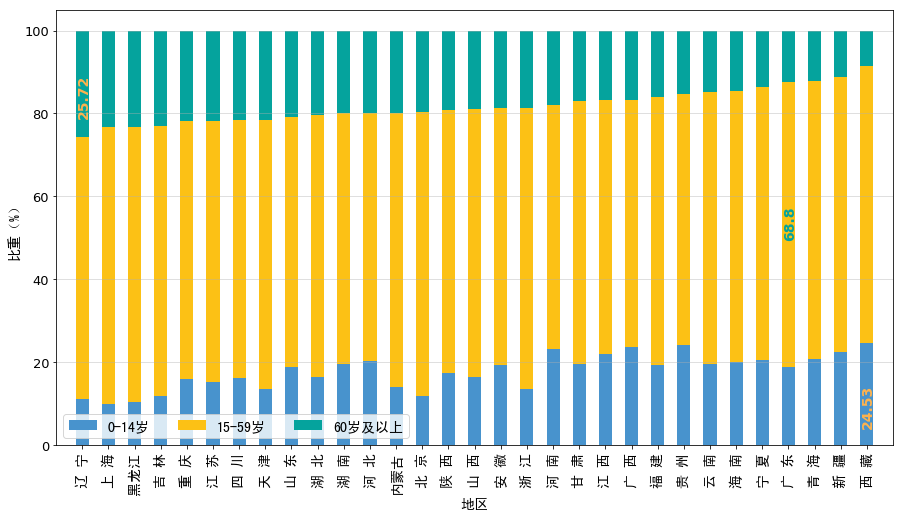

In [17]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
width = 0.5
rect1 = axarr.bar(age_df.index,
                  age_df['比重0-14岁'],
                  width=width,
                  color='#4893cd')
rect2 = axarr.bar(age_df.index,
                  age_df['比重15-59岁'],
                  bottom=age_df['比重0-14岁'],
                  width=width,
                  color='#fcc115')
rect3 = axarr.bar(age_df.index,
                  age_df['比重60岁及以上'],
                  bottom=age_df['比重0-14岁']+age_df['比重15-59岁'],
                  width=width,
                  color='#05a39d')

axarr.tick_params(labelsize=13)
axarr.set_xlabel('地区', size=13, fontproperties=fontP)
axarr.set_ylabel('比重（%）', size=13, fontproperties=fontP)
axarr.set_xticks(age_df.index)
axarr.set_xticklabels(age_df['地区'], rotation=90, fontproperties=fontP)
axarr.set_xlim(-1, 31)
axarr.grid(which='major', axis='y', alpha=0.5)

axarr.legend(handles=(rect1, rect2, rect3),
             fontsize=13,
             labels=('0-14岁', '15-59岁', '60岁及以上'),
             ncol=3, loc=3, prop=fontP)

axarr.text(age_df[age_df['比重0-14岁'] == age_df['比重0-14岁'].max()].index[0]-0.23,
           12,
           age_df[age_df['比重0-14岁'] == age_df['比重0-14岁'].max()]['比重0-14岁'].values[0],
           color='#FFB34E',
           rotation=90,
           fontsize=14,
           weight='bold')
axarr.text(age_df[age_df['比重15-59岁'] == age_df['比重15-59岁'].max()].index[0]-0.2,
           55,
           age_df[age_df['比重15-59岁'] == age_df['比重15-59岁'].max()]['比重15-59岁'].values[0],
           color='#05a39d',
           rotation=90,
           fontsize=14,
           weight='bold')
axarr.text(age_df[age_df['比重60岁及以上'] == age_df['比重60岁及以上'].max()].index[0]-0.21,
           87,
           age_df[age_df['比重60岁及以上'] == age_df['比重60岁及以上'].max()]['比重60岁及以上'].values[0],
           color='#FFB34E',
           rotation=90,
           fontsize=14,
           weight='bold')




31个省份中，15—59岁人口比重在65%以上的省份有13个，在60%—65%之间的省份有15个，在60%以下的省份有3个。
除西藏外，其他30个省份65岁及以上老年人口比重均超过7%，其中，12个省份65岁及以上老年人口比重超过14%。

## 人口受教育情况

In [18]:
educ_df = educ_df.sort_values('大学（大专及以上）').reset_index(drop=True)

Text(5500,16.78,'15467')

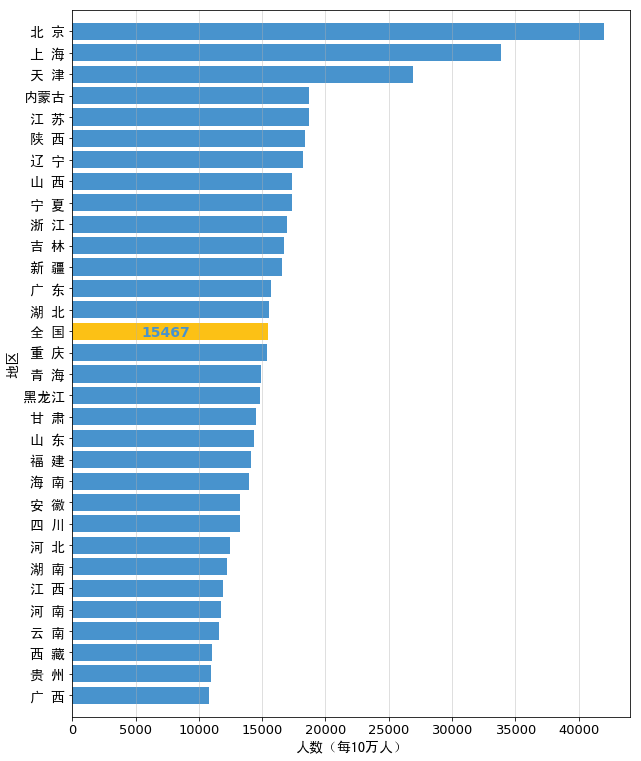

In [19]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(10, 13))
width = 0.4
axarr.barh(np.arange(len(educ_df['地区'])),
           educ_df['大学（大专及以上）'],
           color='#4893cd')
axarr.barh(educ_df[educ_df['地区'] == '全 国'].index.values,
           educ_df[educ_df['地区'] == '全 国']['大学（大专及以上）'],
           color='#fcc115')


axarr.tick_params(labelsize=13)
axarr.set_xlabel('人数（每10万人）', size=13, fontproperties=fontP)
axarr.set_ylabel('地区', size=13, fontproperties=fontP)
axarr.set_ylim(-1, 32)
axarr.set_yticks(educ_df.index)
axarr.set_yticklabels(educ_df['地区'], fontproperties=fontP)

axarr.grid(which='major', axis='x', alpha=0.5)

axarr.text(5500,
           educ_df[educ_df['地区'] == '全 国'].index[0]-0.22,
           educ_df[educ_df['地区'] == '全 国']['大学（大专及以上）'].values[0],
           color='#4893cd',
           fontsize=14,
           weight='bold')


全国人口中，拥有大学（指大专及以上）文化程度的人口为218360767人；拥有高中（含中专）文化程度的人口为213005258人；拥有初中文化程度的人口为487163489人；拥有小学文化程度的人口为349658828人（以上各种受教育程度的人包括各类学校的毕业生、肄业生和在校生）。与2010年第六次全国人口普查相比，每10万人中拥有大学文化程度的由8930人上升为15467人；拥有高中文化程度的由14032人上升为15088人；拥有初中文化程度的由38788人下降为34507人；拥有小学文化程度的由26779人下降为24767人。


In [20]:
educ_province_df = educ_province_df.sort_values('2020年').reset_index(drop=True)

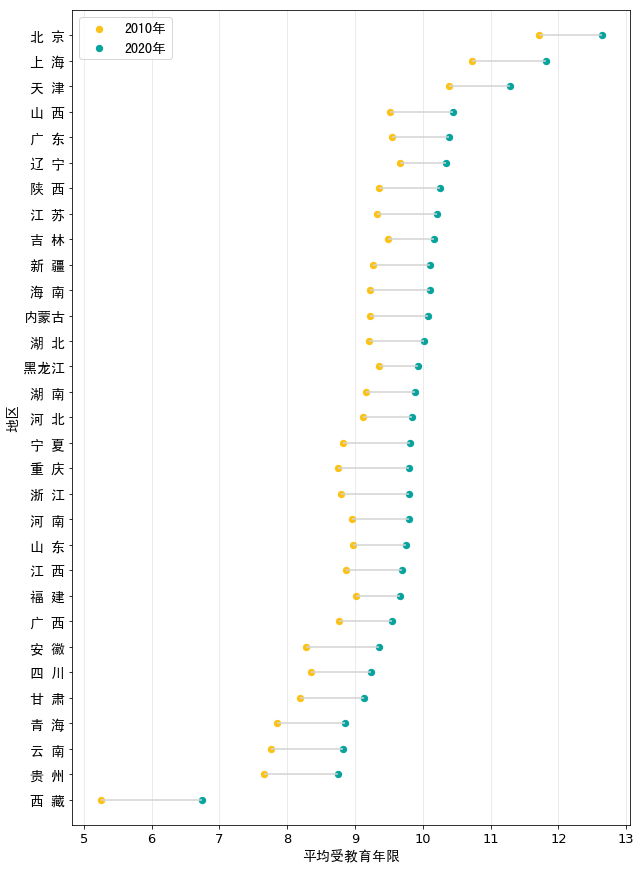

In [21]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(10, 15))
width = 0.4
axarr.hlines(y=np.arange(len(educ_province_df['地区'])),
             xmin=educ_province_df['2010年'],
             xmax=educ_province_df['2020年'],
             color='lightgray')
scatter2010 = axarr.scatter(educ_province_df['2010年'], educ_province_df.index,
                            color='#fcc115', s=40)
scatter2020 = axarr.scatter(educ_province_df['2020年'], educ_province_df.index,
                            color='#05a39d', s=40)

axarr.tick_params(labelsize=13)
axarr.set_xlabel('平均受教育年限', size=13, fontproperties=fontP)
axarr.set_ylabel('地区', size=13, fontproperties=fontP)
axarr.set_ylim(-1, 31)
axarr.set_yticks(educ_province_df.index)
axarr.set_yticklabels(educ_province_df['地区'], fontproperties=fontP)
axarr.grid(which='major', axis='x', alpha=0.3)

axarr.legend(handles=(scatter2010, scatter2020),
             fontsize=13,
             labels=('2010年', '2020年'),
             prop=fontP)



与2010年第六次全国人口普查相比，全国人口中，15岁及以上人口的平均受教育年限由9.08年提高至9.91年。

31个省份中，平均受教育年限在10年以上的省份有13个，在9年至10年之间的省份有14个，在9年以下的省份有4个。

平均受教育年限是将各种受教育程度折算成受教育年限计算平均数得出的，具体的折算标准是：小学=6年，初中=9年，高中=12年，大专及以上=16年。